**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2022*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('talk')
from sqlalchemy import create_engine, text
import plotly
plotly.__version__
import missingno as msno
import pandas_profiling
%matplotlib inline
import plotly.express as px

In [ ]:
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

In [ ]:
interesting_cols=['description','neighborhood_overview','street','neighborhood','city','suburb',
                 'state','zipcode','price','weekly_price','monthly_price','latitude','longitude']
airbnb_df=pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
                     usecols=interesting_cols,low_memory=False)
airbnb_df['zipcode']=pd.to_numeric(airbnb_df.zipcode,errors='coerce')

## Ejercicio 1 SQL: 

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.

4. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



# Procedemos a ver la primera fila de cada una de las tablas a usar. 

In [ ]:
airbnb_df.head(1)

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105.0,-37.772684,145.092133,60,NaN,NaN


In [ ]:
# Estudiamos las características de ambas bases a utilizar (M) #
# En Melb son precios de venta y en airbnb de alquileres?(M) # Si, asi es. En Melb precio de Vta y en Airbnb alquileres temporarios (L)
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   description            22563 non-null  object 
 1   neighborhood_overview  14424 non-null  object 
 2   street                 22895 non-null  object 
 3   neighborhood           17082 non-null  object 
 4   city                   22895 non-null  object 
 5   suburb                 22872 non-null  object 
 6   state                  22834 non-null  object 
 7   zipcode                22749 non-null  float64
 8   latitude               22895 non-null  float64
 9   longitude              22895 non-null  float64
 10  price                  22895 non-null  int64  
 11  weekly_price           2524 non-null   float64
 12  monthly_price          1891 non-null   float64
dtypes: float64(5), int64(1), object(7)
memory usage: 2.3+ MB


In [ ]:
airbnb_df.zipcode.value_counts()

3000.0     3367
3006.0     1268
3182.0     1135
3141.0      881
3004.0      728
           ... 
3785.0        1
3096.0        1
30122.0       1
3912.0        1
4068.0        1
Name: zipcode, Length: 247, dtype: int64

In [ ]:
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [ ]:
melb_df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


# Creamos la conexion a la base de datos.

In [ ]:
engine=create_engine('sqlite:///grupo13.sqlite3',echo=True)
engine

Engine(sqlite:///grupo13.sqlite3)

# Cargamos las dos tablas a la base de datos creada. 

In [ ]:
melb_df.to_sql(name='melb_df',con=engine,if_exists='replace');
airbnb_df.to_sql(name='airbnb_df',con=engine,if_exists='replace');

2022-05-30 00:03:32,732 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb_df")
2022-05-30 00:03:32,741 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:32,743 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("melb_df")
2022-05-30 00:03:32,748 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:32,759 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-05-30 00:03:32,771 INFO sqlalchemy.engine.Engine 
CREATE TABLE melb_df (
	"index" BIGINT, 
	"Suburb" TEXT, 
	"Address" TEXT, 
	"Rooms" BIGINT, 
	"Type" TEXT, 
	"Price" FLOAT, 
	"Method" TEXT, 
	"SellerG" TEXT, 
	"Date" TEXT, 
	"Distance" FLOAT, 
	"Postcode" FLOAT, 
	"Bedroom2" FLOAT, 
	"Bathroom" FLOAT, 
	"Car" FLOAT, 
	"Landsize" FLOAT, 
	"BuildingArea" FLOAT, 
	"YearBuilt" FLOAT, 
	"CouncilArea" TEXT, 
	"Lattitude" FLOAT, 
	"Longtitude" FLOAT, 
	"Regionname" TEXT, 
	"Propertycount" FLOAT
)


2022-05-30 00:03:32,772 INFO sqlalchemy.engine.Engine [no key 0.00158s] ()
2022-05-30 00:03:32,791 INFO sqlalchemy.

# Procedemos a leer la primera fila de cada tabla, pero esta vez sacandola desde la base de datos creada (para comprobar que fue cargada correctamente).

In [ ]:
df=pd.read_sql_table("melb_df",engine);
df1=pd.read_sql_table("airbnb_df",engine);

2022-05-30 00:03:36,343 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2022-05-30 00:03:36,355 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:36,359 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' ORDER BY name
2022-05-30 00:03:36,367 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:36,375 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb_df")
2022-05-30 00:03:36,381 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:36,392 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2022-05-30 00:03:36,396 INFO sqlalchemy.engine.Engine [raw sql] ('melb_df',)
2022-05-30 00:03:36,399 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("melb_df")
2022-05-30 00:03:36,401 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:36,404 INFO sqlalchemy.engine.Engine PRAG

In [ ]:
#guardamos una copia antes de las transformaciones que le aplicaremos (M)#
airbnb_df2=airbnb_df.copy()

# Aqui abajo vemos la primera fila de la tabla melb_df, y confirmamos que coincide tal como queremos

In [ ]:
df.head(1)

,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0


# Aqui abajo vemos la primera fila de la tabla airbnb_df, y confirmamos que coincide tal como queremos

In [ ]:
df1.head(1)

,index,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105.0,-37.772684,145.092133,60,NaN,NaN


# 3)a- Cantidad de registros totales por ciudad.

In [ ]:
query="""
SELECT
  city,
  count(*) AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY city
ORDER BY count(*) DESC 
LIMIT 3
"""
pd.read_sql_query(query,engine)

2022-05-30 00:03:37,863 INFO sqlalchemy.engine.Engine 
SELECT
  city,
  count(*) AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY city
ORDER BY count(*) DESC 
LIMIT 3

2022-05-30 00:03:37,872 INFO sqlalchemy.engine.Engine [raw sql] ()


,city,Cantidad_de_registros
0,Melbourne,7368
1,Port Phillip,2808
2,Yarra,2049


## 3)b- Cantidad de registros totales por barrio y ciudad.

In [ ]:
query1="""
SELECT
  neighborhood AS Barrios_de_Melbourne,
    count(*) AS Cantidad_de_registros
FROM airbnb_df 
WHERE city='Melbourne'
GROUP BY Barrios_de_Melbourne
ORDER BY count(*) DESC
LIMIT 3
"""
pd.read_sql_query(query1,engine)

2022-05-30 00:03:37,965 INFO sqlalchemy.engine.Engine 
SELECT
  neighborhood AS Barrios_de_Melbourne,
    count(*) AS Cantidad_de_registros
FROM airbnb_df 
WHERE city='Melbourne'
GROUP BY Barrios_de_Melbourne
ORDER BY count(*) DESC
LIMIT 3

2022-05-30 00:03:37,972 INFO sqlalchemy.engine.Engine [raw sql] ()


,Barrios_de_Melbourne,Cantidad_de_registros
0,Central Business District,3726
1,Southbank,1204
2,Carlton,582


In [ ]:
query="""
SELECT
  city as Ciudad, neighborhood as Barrio, count(*) AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY Barrio
ORDER BY count(*) DESC
LIMIT 3 
"""
pd.read_sql_query(query,engine)

2022-05-30 00:03:38,044 INFO sqlalchemy.engine.Engine 
SELECT
  city as Ciudad, neighborhood as Barrio, count(*) AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY Barrio
ORDER BY count(*) DESC
LIMIT 3 

2022-05-30 00:03:38,050 INFO sqlalchemy.engine.Engine [raw sql] ()


,Ciudad,Barrio,Cantidad_de_registros
0,Monash,None,5813
1,Melbourne,Central Business District,3726
2,Melbourne,Southbank,1248


# 4 Combinamos los datasets mediante comando de JOIN

In [ ]:
airbnb_df.sample(3)

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
6062,"My place is close to Cafes, public transport a...",NaN,"Essendon, VIC, Australia",Brunswick,Moonee Valley,Essendon,VIC,3040.0,-37.752999,144.926393,100,NaN,NaN
21208,"Very clean two-storey house with 3 bedrooms, ...",The neighbourhood is nice and quiet. Friendly...,"Truganina, VIC, Australia",NaN,Wyndham,Truganina,VIC,3029.0,-37.842127,144.724848,28,NaN,NaN
5602,Large double room in 2 bedroom townhouse. The ...,"Peaceful, safe leafy suburb with close proximi...","Alphington, VIC, Australia",Alphington,Darebin,Alphington,VIC,3078.0,-37.778562,145.032124,50,NaN,NaN


In [ ]:
airbnb_df2['zipcode']=pd.to_numeric(airbnb_df2.zipcode,errors='coerce')
relevant_cols =['price','weekly_price','monthly_price']
airbnb_df2 = airbnb_df2[relevant_cols + ['zipcode']].groupby('zipcode').mean().reset_index()[:5]
airbnb_df2.to_sql(name='airbnb_df2',con=engine,if_exists='replace');


2022-05-30 00:03:38,232 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("airbnb_df2")
2022-05-30 00:03:38,237 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:38,241 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("airbnb_df2")
2022-05-30 00:03:38,244 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-05-30 00:03:38,251 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-05-30 00:03:38,253 INFO sqlalchemy.engine.Engine 
CREATE TABLE airbnb_df2 (
	"index" BIGINT, 
	zipcode FLOAT, 
	price FLOAT, 
	weekly_price FLOAT, 
	monthly_price FLOAT
)


2022-05-30 00:03:38,274 INFO sqlalchemy.engine.Engine [no key 0.02043s] ()
2022-05-30 00:03:38,296 INFO sqlalchemy.engine.Engine CREATE INDEX ix_airbnb_df2_index ON airbnb_df2 ("index")
2022-05-30 00:03:38,298 INFO sqlalchemy.engine.Engine [no key 0.00186s] ()
2022-05-30 00:03:38,319 INFO sqlalchemy.engine.Engine COMMIT
2022-05-30 00:03:38,324 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-05-30 00:03:38,333 INFO sqlalchemy.en

In [ ]:
query2="""
SELECT * 
FROM melb_df LEFT JOIN airbnb_df2 ON melb_df.Postcode=airbnb_df2.zipcode;
"""
pd.read_sql_query(query2,engine)

2022-05-30 00:03:38,373 INFO sqlalchemy.engine.Engine 
SELECT * 
FROM melb_df LEFT JOIN airbnb_df2 ON melb_df.Postcode=airbnb_df2.zipcode;

2022-05-30 00:03:38,391 INFO sqlalchemy.engine.Engine [raw sql] ()


,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,index,zipcode,price,weekly_price,monthly_price
0,0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,...,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,NaN,NaN,NaN,NaN,NaN
1,1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,...,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,NaN,NaN,NaN,NaN,NaN
2,2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,...,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,NaN,NaN,NaN,NaN,NaN
3,3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,...,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,NaN,NaN,NaN,NaN,NaN
4,4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,...,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,...,None,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,NaN,NaN,NaN,NaN,NaN
13576,13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,...,None,-37.85927,144.87904,Western Metropolitan,6380.0,NaN,NaN,NaN,NaN,NaN
13577,13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,...,None,-37.85274,144.88738,Western Metropolitan,6380.0,NaN,NaN,NaN,NaN,NaN
13578,13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,...,None,-37.85908,144.89299,Western Metropolitan,6380.0,NaN,NaN,NaN,NaN,NaN


## Ejercicio 2: 

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar las columnas seleccionadas y las que no lo fueron.
 - Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

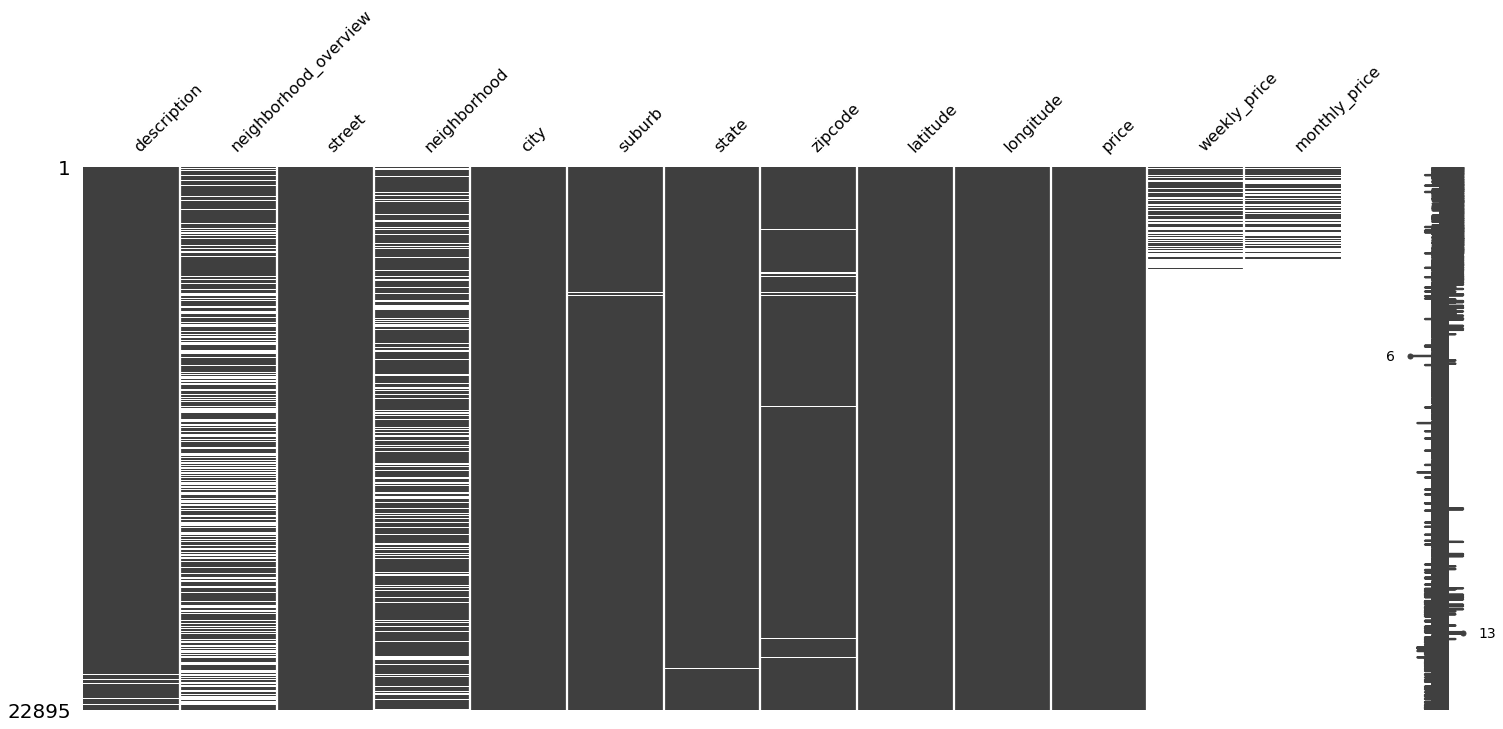

In [ ]:
import missingno as msno
msno.matrix(airbnb_df);

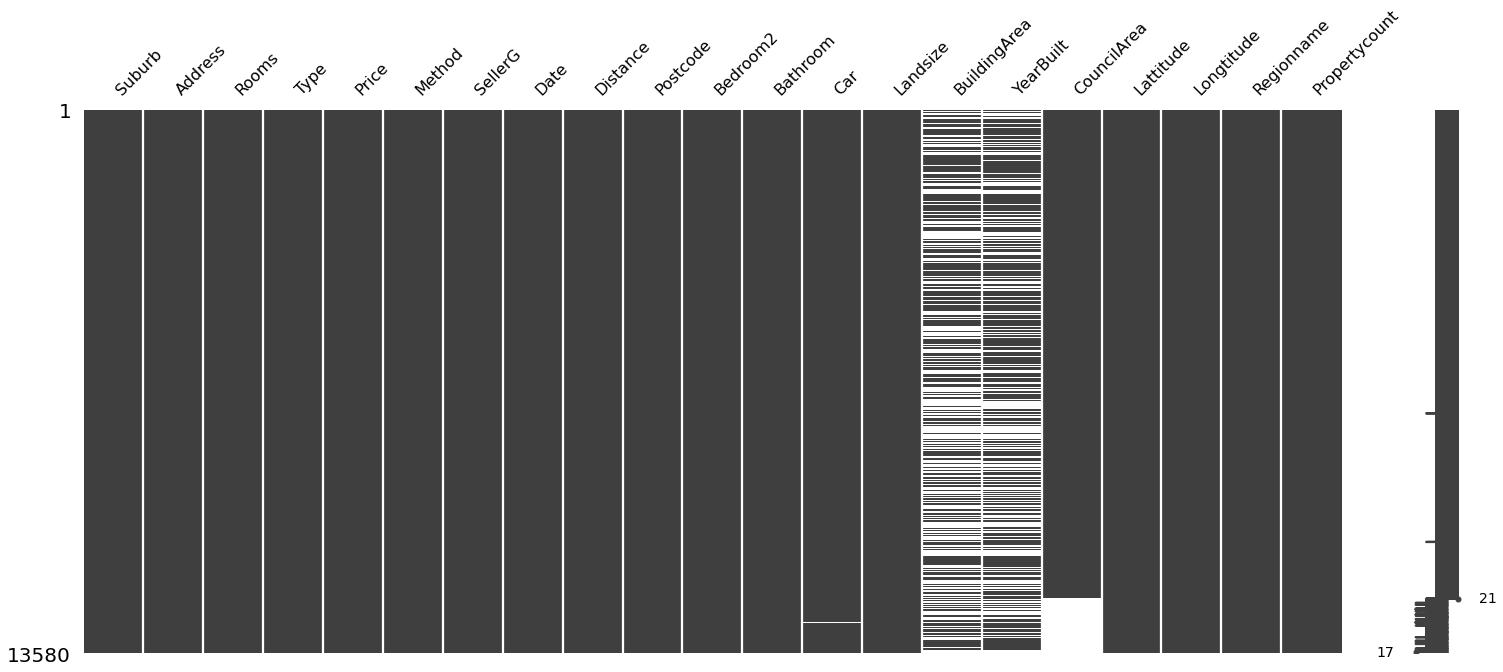

In [ ]:
msno.matrix(melb_df);

            Rooms  Bedroom2
Rooms     1.00000   0.94419
Bedroom2  0.94419   1.00000
Coef de correlación entra ambas variables:  0.94 



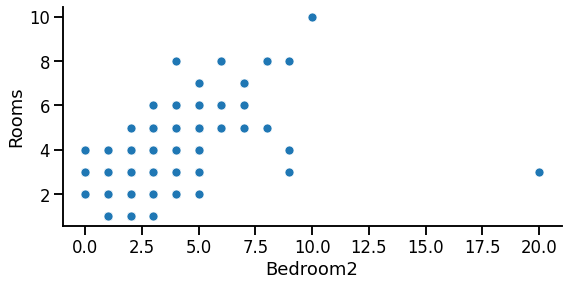

In [ ]:
#calculamos la correlacion entre las columnas rooms y Bedroom2 porque por el nombre parecen indicar el mismo dato
sns.pairplot(data=melb_df, y_vars=['Rooms'],
                 x_vars=['Bedroom2'],
                 aspect=2, height=4)
corr_df = melb_df[['Rooms','Bedroom2']].corr()
print(corr_df)
print('Coef de correlación entra ambas variables: ', round(corr_df.iloc[0]['Bedroom2'],2) ,'\n')

# Seleccionado de columnas de melb_df
### Procedemos a eliminar la variable Address porque cuenta con una alta cardinalidad, que no nos sirve para el estudio actual.
### Eliminamos tambien la variable Bedroom2, ya que existe la variable Rooms, que apunta al mismo dato (cantidad de cuartos o piezas en cada casa). 
### Eliminamos la variable SellerG, donde tan solo sale el nombre del vendedor, dato que no nos sirve y trae una alta cardinalidad
### Eliminamos las variables BuildingArea y YearBuilt por tener gran cantidad de Nans. 
### Link del Excel donde se detalla la justificación de la selección de variables: https://docs.google.com/spreadsheets/d/17VmyocYCaa7pjUqVKAwUFhX34499nhZs/edit?usp=sharing&ouid=106561172859044487281&rtpof=true&sd=true

In [ ]:
melb_df=melb_df.drop(['Address', 'Method', 'Date', 'CouncilArea', 'Lattitude', 'Longtitude','Bedroom2','SellerG'],axis=1)

### Estudiando los precios del dataset, decidimos eliminar el percentil 99% de los datos; ya que modificaba mucho la media. 
### No se eliminan valores de "Precio de Venta" bajos porque no consideramos que sean outliers. 

In [ ]:
melb_df['Price'].describe().apply(lambda s: '{0:.2f}'.format(s))

count      13580.00
mean     1075684.08
std       639310.72
min        85000.00
25%       650000.00
50%       903000.00
75%      1330000.00
max      9000000.00
Name: Price, dtype: object

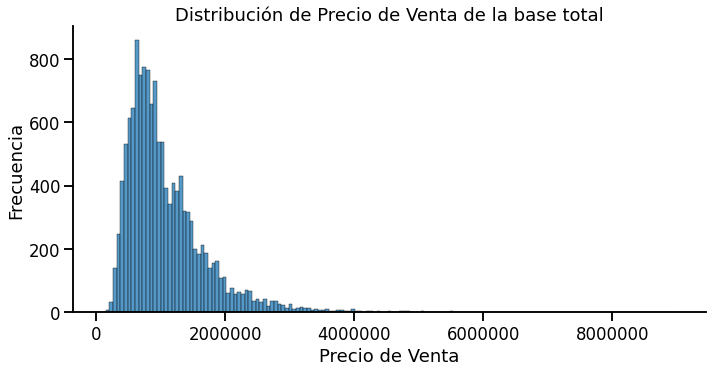

In [ ]:
sns.displot(melb_df['Price'], aspect=2) 
plt.ylabel('Frecuencia')
plt.xlabel('Precio de Venta')
plt.title('Distribución de Precio de Venta de la base total')
plt.ticklabel_format(style='plain', axis='x')

In [ ]:
melb_df= melb_df[melb_df['Price'] < melb_df['Price'] .quantile(0.99)]

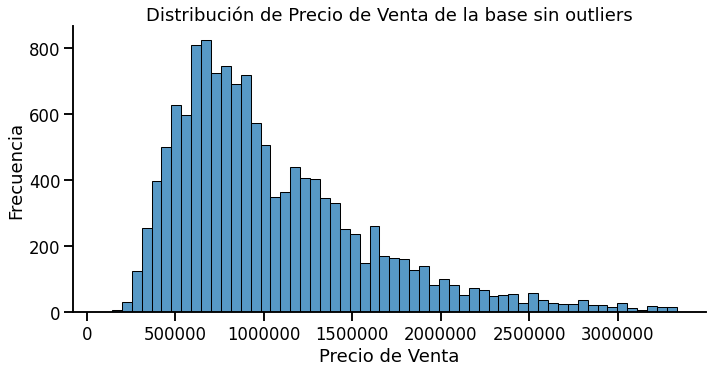

In [ ]:
sns.displot(melb_df['Price'], aspect=2) 
plt.ylabel('Frecuencia')
plt.xlabel('Precio de Venta')
plt.title('Distribución de Precio de Venta de la base sin outliers')

plt.ticklabel_format(style='plain', axis='x')

# Seleccionado de columnas de airbnb_df
### Decidimos elegir las columnas

In [ ]:
airbnb_df2 = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')
interesting_cols = [
  'description', 'neighborhood_overview',
  'street','neighborhood', 'city', 'suburb', 'state',
  'zipcode','price', 'weekly_price', 'monthly_price',
  'review_scores_value','review_scores_location']
airbnb_df2 = airbnb_df2[interesting_cols]
airbnb_df2.head()
airbnb_df2['zipcode'] = pd.to_numeric(airbnb_df2.zipcode, errors='coerce')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (35,77) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Utilizaremos el precio, reviews del valor y localizacion

In [ ]:
airbnb_df2[['price','review_scores_value','review_scores_location']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,22895.0,148.004368,210.883253,0.0,71.0,111.0,165.0,12624.0
review_scores_value,17160.0,9.478205,0.892818,2.0,9.0,10.0,10.0,10.0
review_scores_location,17162.0,9.714078,0.697961,2.0,10.0,10.0,10.0,10.0


## Crearemos un df agrupado con la media de los tres datos y agrupados por zipcode para luego unirla al df de melbourne 

In [ ]:
relevant_cols = ['price','review_scores_value','review_scores_location', 'zipcode']

airbnb_price_by_zipcode = airbnb_df2[relevant_cols].groupby('zipcode')\
  .agg({'price': ['mean', 'count'], 'review_scores_value': 'mean',
        'review_scores_location': 'mean'})\
  .reset_index()

airbnb_price_by_zipcode.columns = [
  ' '.join(col).strip()
  for col in airbnb_price_by_zipcode.columns.values]

airbnb_price_by_zipcode = airbnb_price_by_zipcode.rename(
    columns={'price mean': 'airbnb_price_mean',
             'price count': 'airbnb_record_count',
             'review_scores_value mean': 'review_scores_value_mean',
             'review_scores_location mean': 'review_scores_location_mean'}
)
print(f"Long: {len(airbnb_price_by_zipcode)}")
airbnb_price_by_zipcode.describe()

Long: 247


,zipcode,airbnb_price_mean,airbnb_record_count,review_scores_value_mean,review_scores_location_mean
count,247.000000,247.000000,247.000000,235.000000,235.000000
mean,3508.538462,149.900412,92.101215,9.544932,9.534643
std,1903.914390,84.872988,261.914701,0.324120,0.372290
min,2010.000000,37.000000,1.000000,7.500000,7.500000
25%,3072.500000,93.744681,8.500000,9.417289,9.333333
50%,3148.000000,126.012987,27.000000,9.571429,9.575758
75%,3589.500000,187.168478,73.000000,9.725338,9.831200
max,30122.000000,759.083333,3367.000000,10.000000,10.000000


## Nos quedamos con los zipcodes que tengan una cantidad minima de 2 registros ya que 8,5 es el quantil 25%, y suena razonable

In [ ]:
airbnb_price_by_zipcode = airbnb_price_by_zipcode[(airbnb_price_by_zipcode.airbnb_record_count >= 2)]
print(f"Long: {len(airbnb_price_by_zipcode)}")
airbnb_price_by_zipcode.describe()

Long: 227


,zipcode,airbnb_price_mean,airbnb_record_count,review_scores_value_mean,review_scores_location_mean
count,227.000000,227.000000,227.000000,226.000000,226.000000
mean,3261.180617,148.442299,100.127753,9.531234,9.516111
std,293.525033,84.096631,271.791966,0.316835,0.367609
min,3000.000000,43.500000,2.000000,7.500000,7.500000
25%,3070.500000,94.180578,11.500000,9.404167,9.333333
50%,3142.000000,125.275862,32.000000,9.571429,9.553968
75%,3203.000000,178.866667,80.500000,9.695804,9.800000
max,3980.000000,759.083333,3367.000000,10.000000,10.000000


## Quitamos los registros que cuenten con valores nulos

In [ ]:
airbnb_price_by_zipcode = airbnb_price_by_zipcode.dropna()

# Procedemos a unir los datasets en uno solo, para conseguir mayor informacion disponible

In [ ]:
merged_sales_df = melb_df.merge(
    airbnb_price_by_zipcode, how='left',
    left_on='Postcode', right_on='zipcode'
)
print(merged_sales_df.columns)
print(len(merged_sales_df))
merged_sales_df[:5]

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Distance', 'Postcode', 'Bathroom',
       'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Regionname',
       'Propertycount', 'zipcode', 'airbnb_price_mean', 'airbnb_record_count',
       'review_scores_value_mean', 'review_scores_location_mean'],
      dtype='object')
13444


,Suburb,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname,Propertycount,zipcode,airbnb_price_mean,airbnb_record_count,review_scores_value_mean,review_scores_location_mean
0,Abbotsford,2,h,1480000.0,2.5,3067.0,1.0,1.0,202.0,NaN,NaN,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
1,Abbotsford,2,h,1035000.0,2.5,3067.0,1.0,0.0,156.0,79.0,1900.0,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
2,Abbotsford,3,h,1465000.0,2.5,3067.0,2.0,0.0,134.0,150.0,1900.0,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
3,Abbotsford,3,h,850000.0,2.5,3067.0,2.0,1.0,94.0,NaN,NaN,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
4,Abbotsford,4,h,1600000.0,2.5,3067.0,1.0,2.0,120.0,142.0,2014.0,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115


In [ ]:
merged_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13444 entries, 0 to 13443
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Suburb                       13444 non-null  object 
 1   Rooms                        13444 non-null  int64  
 2   Type                         13444 non-null  object 
 3   Price                        13444 non-null  float64
 4   Distance                     13444 non-null  float64
 5   Postcode                     13444 non-null  float64
 6   Bathroom                     13444 non-null  float64
 7   Car                          13382 non-null  float64
 8   Landsize                     13444 non-null  float64
 9   BuildingArea                 7040 non-null   float64
 10  YearBuilt                    8112 non-null   float64
 11  Regionname                   13444 non-null  object 
 12  Propertycount                13444 non-null  float64
 13  zipcode         

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [ ]:
merged_sales_df.to_csv(index=False);

In [ ]:
#BAJAMOS LA BASE PARA PODER UTILIZARLA EN EL PROXIMO ENTREGABLE#
merged_sales_df.to_csv("merged_sales_df.csv", index=None)
from google.colab import files
files.download('merged_sales_df.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Otras variables que pueden servir para combinar los datos son `'type'` y  `'property_type'`. En la columna `'type'` de **melb_df** hay solamente 3 tipos diferentes y categorizados por la primera letra en estos son: House (h), Unit (u) y Townhouse (t), mientras que en `'property_type'` de **airbnb_df** hay como 35 tipos diferentes entre los cuales se pueden encontrar House y Townhouse. Como Unit puede abarcar muchas propiedades, decidimos no tomarla en la combinación, para no proveer información errónea. Los datos de **airbnb_df** se pueden agrupar en estos dos conjuntos, House y Townhouse, y tomar las medias de los precios. Como se hizo anteriormente con `'zipcode'`. 
Creemos que sería adecuado, ya que al combinar los datos permite una mayor información en el caso en que alguien quiera invertir en comprar una casa para luego ponerla en alquiler por airbnb.